# **Keras - Transfer Learning and Fine Tuning with Cats vs Dogs**

---


## **Transfer-learning workflow**

1. We instantiate a **base model and load pre-trained weighs** into it.
2. **Freeze** all layers in the base model by setting `trainable = False`.
3. Create a **new model on top** of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.


![](https://github.com/rajeevratan84/ModernComputerVision/blob/main/Screenshot%202021-05-11%20at%2011.49.01%20pm.png?raw=true)

### **1. Load a base model with pre-trained weights (ImageNet)**


In [ ]:
# Transfer learning is most useful when working with very small datasets.
# To keep our dataset small, we will use 40% of the original training data for training, 
# Also 10% for validation, and 10% for testing.

# Import of libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load( "cats_vs_dogs",
                                              # Reserve 10% for validation and 10% for test
                                              split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
                                              as_supervised=True,  # Include labels
                                             )

print(f'Number of training samples: {tf.data.experimental.cardinality(train_ds)}')
print(f'Number of validation samples: {tf.data.experimental.cardinality(validation_ds)}')
print(f'Number of test samples: {tf.data.experimental.cardinality(test_ds)}')

In [ ]:
# Plot first 9 images in the training dataset. Notice they're all different sizes.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for index, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, index + 1)
    plt.imshow(image)
    plt.title('Cat' if int(label) == 0 else 'Dog')
    plt.axis("off")

## **2. Standardize Our Data**


In [ ]:
# Standardize image to 150 X 150 and Normalize pixel value between -1 and 1.
batch_size = 32
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

# Batch the data and use caching & prefetching to optimize loading speed.
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

#### **Visualize our Data Augmentations**

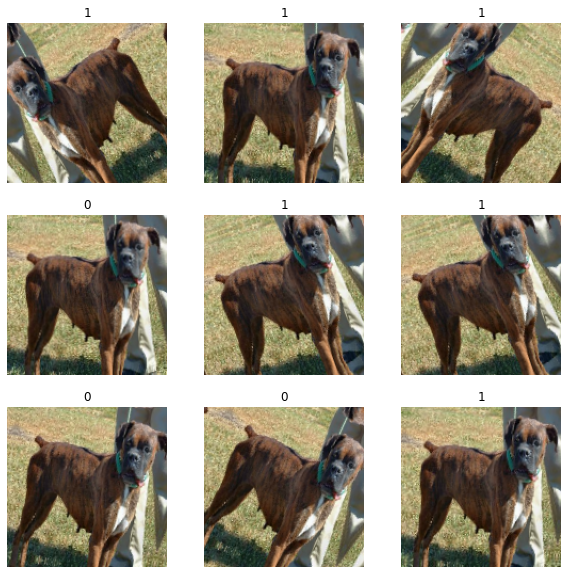

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Because we have a small dataset, we use augmentation. 
# This helps expose the model to different aspects of the training data while slowing down overfitting.
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal"),
                                      layers.experimental.preprocessing.RandomRotation(0.1),])

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## **3. Building our model**

Built a model:

- We add a `Normalization` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

- We'll be using the **Xception Model** as our base.

In [ ]:
base_model = keras.applications.Xception(weights="imagenet",  # Load weights pre-trained on ImageNet.
                                         input_shape=(150, 150, 3),
                                         include_top=False,)
                                         # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale = 1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

## **4. Train the Top Layer**

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()],
              )

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

## **5. Fine Tuning**

In [ ]:
# Unfreeze the base_model and train it with low learning rate. 
# Note that it keeps running in inference mode since we passed `training=False` when calling it. 
# This means that the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.

base_model.trainable = True
model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()],)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)